# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [1]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install hands-on-ai
!pip install pyinputplus
!pip install spacy dateparser
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.5/155.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.0/352.0 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.7/517.7 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.8/456.8 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 39.3 MB/s eta 0:00:00
  Attempting uninstall: jiter
    Found existing

In [ ]:
import os

os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
os.environ['HANDS_ON_AI_API_KEY'] = input('Enter your API key: ')

KeyboardInterrupt: Interrupted by user

## 📦 Setup and Configuration
Import required packages and setup environment.

In [2]:
import os
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import json
import re
import math

try:
    import pyinputplus as pyip
except Exception:
    pyip = None

WEATHER_AVAILABLE = False
if 'seaborn-v0_8' in plt.style.available:
    plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)


## 🌤️ Weather Data Functions

In [3]:
import json
import requests
import difflib
from urllib.parse import quote

def _safe(d, *keys, default=None):
    """Safely navigate nested dict/list without KeyError or IndexError."""
    cur = d
    for k in keys:
        if isinstance(cur, dict) and k in cur:
            cur = cur[k]
        elif isinstance(cur, list) and isinstance(k, int) and 0 <= k < len(cur):
            cur = cur[k]
        else:
            return default
    return cur

def get_weather_data(location, forecast_days=3):
    """
    Retrieve weather data using wttr.in JSON (3-day forecast).
    Gracefully handles:
      - Empty or invalid input
      - Network or HTTP errors
      - Invalid or missing JSON/forecast
    """
    if not isinstance(location, str) or not location.strip():
        return {"error": "Location must be a non-empty string.", "location": location}

    user_input = location.strip()
    try:
        days = max(1, min(int(forecast_days), 3))
    except Exception:
        days = 3

    url = f"https://wttr.in/{quote(user_input)}?format=j1"

    try:
        resp = requests.get(url, timeout=10, headers={"User-Agent": "WeatherWise/1.0"})
        if resp.status_code == 404:
            return {"error": f"No weather found for '{user_input}'.", "location": user_input}
        resp.raise_for_status()
        data = resp.json()
    except requests.exceptions.Timeout:
        return {"error": "Timeout contacting weather service.", "location": user_input}
    except requests.exceptions.HTTPError as e:
        return {"error": f"Weather service error: {e.response.status_code}", "location": user_input}
    except json.JSONDecodeError:
        return {"error": "Weather service returned invalid JSON.", "location": user_input}
    except Exception as e:
        return {"error": f"Could not retrieve weather data: {e}", "location": user_input}

    # --- Normalize response fields ---
    nearest  = _safe(data, "nearest_area", 0, default={}) or {}
    current  = _safe(data, "current_condition", 0, default={}) or {}
    forecast = _safe(data, "weather", default=[]) or []

    if not isinstance(forecast, list) or not forecast:
        return {"error": f"No forecast data available for '{user_input}'.", "location": user_input}

    resolved_location = (
        _safe(nearest, "areaName", 0, "value", default=user_input)
        or user_input
    )

    # Similarity between user input and resolved location (helps warn on odd matches)
    try:
        similarity = difflib.SequenceMatcher(
            a=user_input.lower(), b=str(resolved_location).lower()
        ).ratio()
    except Exception:
        similarity = 0.0

    # --- Unified structure for rest of app ---
    return {
        "source": "wttr.in",
        "requested_location": user_input,     # what the user typed
        "location": resolved_location,        # best match (may differ slightly)
        "display_location": user_input,       # preserve user's original input
        "resolved_location": resolved_location,
        "resolved_similarity": similarity,
        "current": current,
        "forecast": forecast[:days],
        "raw": data,
    }


## 📊 Visualisation Functions

In [4]:
import math
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ===== Helper functions =====
def _daily_series_from_wttrin(weather_data):
    """Extract daily values: dates, hiC, loC, avg_precip(mm), avg_pop(%)."""
    days = (weather_data or {}).get("forecast", []) or []
    dates, hiC, loC, avg_precip, avg_pop = [], [], [], [], []

    for d in days:
        # Parse date safely
        dt_str = d.get("date")
        try:
            dt = datetime.strptime(dt_str, "%Y-%m-%d")
        except Exception:
            # Skip malformed day entries
            continue
        dates.append(dt)

        # Hi/Lo temps (handle missing / non-numeric)
        hi = d.get("maxtempC")
        lo = d.get("mintempC")
        hiC.append(float(hi) if hi not in (None, "") else math.nan)
        loC.append(float(lo) if lo not in (None, "") else math.nan)

        # Hourly aggregates
        hrs = d.get("hourly") or []
        if hrs:
            try:
                mm_vals  = [float(h.get("precipMM", 0)) for h in hrs]
            except Exception:
                mm_vals = []
            try:
                pop_vals = [float(h.get("chanceofrain", 0))
                            for h in hrs if h.get("chanceofrain") is not None]
            except Exception:
                pop_vals = []

            avg_precip.append(sum(mm_vals)/len(mm_vals) if mm_vals else 0.0)
            avg_pop.append(sum(pop_vals)/len(pop_vals) if pop_vals else math.nan)
        else:
            avg_precip.append(math.nan)
            avg_pop.append(math.nan)

    return dates, hiC, loC, avg_precip, avg_pop


def _title_loc_and_range(weather_data, dates):
    loc = weather_data.get("display_location") or weather_data.get("requested_location") or "Your city"
    if dates:
        drange = f"{dates[0].strftime('%d %b')} – {dates[-1].strftime('%d %b')}"
        return f"{loc} · {drange}"
    return loc


def _shade_weekends(ax, dates, alpha=0.08):
    """Shade full-day spans for weekends so it’s visible."""
    for dt in dates:
        if dt.weekday() in (5, 6):
            start = dt - timedelta(hours=12)
            end   = dt + timedelta(hours=12)
            ax.axvspan(start, end, alpha=alpha)


# ===== Temperature =====
def create_temperature_visualisation(weather_data, output_type='display'):
    """Line chart of daily high/low with comfort band and rolling mid-temp."""
    if not isinstance(weather_data, dict) or "forecast" not in weather_data:
        print("No weather data to visualize."); return
    dates, hiC, loC, _, _ = _daily_series_from_wttrin(weather_data)
    if not dates:
        print("No forecast data to visualize."); return

    has_hi = any(isinstance(v, (int, float)) and math.isfinite(v) for v in hiC)
    has_lo = any(isinstance(v, (int, float)) and math.isfinite(v) for v in loC)

    fig, ax = plt.subplots()

    if not (has_hi or has_lo):
        ax.set_title(f"Temperatures — {_title_loc_and_range(weather_data, dates)}")
        ax.text(0.5, 0.5, "No temperature data from provider.", ha="center", va="center",
                transform=ax.transAxes)
        ax.axis("off")
        if output_type == 'figure': return fig
        plt.show()
        return

    # Rolling mean of mid temps (3-pt window), robust to NaNs
    mids = []
    for h, l in zip(hiC, loC):
        m = (h + l) / 2 if (isinstance(h,(int,float)) and isinstance(l,(int,float))
                            and math.isfinite(h) and math.isfinite(l)) else math.nan
        mids.append(m)
    roll = []
    for i in range(len(mids)):
        win = mids[max(0, i-1):min(len(mids), i+2)]
        vals = [v for v in win if isinstance(v,(int,float)) and math.isfinite(v)]
        roll.append(sum(vals)/len(vals) if vals else math.nan)

    # Comfort band + weekend shading
    ax.axhspan(18, 26, alpha=0.12)
    _shade_weekends(ax, dates, alpha=0.08)

    # High/low + band + rolling mean
    if has_hi:
        ax.plot(dates, hiC, marker="o", markersize=7, linewidth=2, label="High")
    if has_lo:
        ax.plot(dates, loC, marker="o", markersize=7, linewidth=2, label="Low")
    if has_hi and has_lo:
        ax.fill_between(dates, loC, hiC, alpha=0.25, linewidth=0)
    if any(isinstance(v,(int,float)) and math.isfinite(v) for v in roll):
        ax.plot(dates, roll, linestyle="--", linewidth=2, label="Rolling mean")

    # Annotate extrema when available
    valid_hi_idx = [i for i,v in enumerate(hiC) if isinstance(v,(int,float)) and math.isfinite(v)]
    valid_lo_idx = [i for i,v in enumerate(loC) if isinstance(v,(int,float)) and math.isfinite(v)]
    if valid_hi_idx:
        i_max = max(valid_hi_idx, key=lambda i: hiC[i])
        ax.annotate(f"Max {hiC[i_max]:.0f}°C", (dates[i_max], hiC[i_max]),
                    xytext=(6, 10), textcoords="offset points")
    if valid_lo_idx:
        i_min = min(valid_lo_idx, key=lambda i: loC[i])
        ax.annotate(f"Min {loC[i_min]:.0f}°C", (dates[i_min], loC[i_min]),
                    xytext=(6, -16), textcoords="offset points")

    ax.set_title(f"Temperatures — {_title_loc_and_range(weather_data, dates)}")
    ax.set_xlabel("Date"); ax.set_ylabel("°C")
    if has_hi or has_lo:
        ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d %b'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.grid(True, which="major", axis="y", alpha=0.3)
    plt.xticks(rotation=0)
    plt.tight_layout()
    if output_type == 'figure': return fig
    plt.show()


# ===== Precipitation =====
def create_precipitation_visualisation(weather_data, output_type='display'):
    """Avg precip (mm) with chance-of-rain scaled to left axis + % on right axis."""
    if not isinstance(weather_data, dict) or "forecast" not in weather_data:
        print("No weather data to visualize."); return
    days = weather_data.get("forecast", [])
    if not days:
        print("No forecast data to visualize."); return

    dates, avg_precip, avg_pop = [], [], []
    for d in days:
        dt_str = d.get("date")
        try:
            dt = datetime.strptime(dt_str, "%Y-%m-%d")
        except Exception:
            continue
        hrs = d.get("hourly", []) or []
        mm  = []
        pop = []
        for h in hrs:
            try:
                mm.append(float(h.get("precipMM", 0)))
            except Exception:
                pass
            try:
                if h.get("chanceofrain") is not None:
                    pop.append(float(h.get("chanceofrain", 0)))
            except Exception:
                pass
        dates.append(dt)
        avg_precip.append(sum(mm)/len(mm) if mm else 0.0)
        avg_pop.append(sum(pop)/len(pop) if pop else float("nan"))

    if not dates:
        print("No data to visualize."); return

    fig, ax = plt.subplots()
    ax.plot(dates, avg_precip, marker="o", markersize=6, linewidth=2, label="Avg precip (mm)")

    finite_pops = [p for p in avg_pop if isinstance(p, (int, float)) and math.isfinite(p)]
    has_pop = len(finite_pops) > 0

    if has_pop:
        max_precip = max(avg_precip) if avg_precip else 1.0
        max_pop = max(finite_pops) if finite_pops else 100.0
        target_peak_mm = max(max_precip, 1.0)
        scale = (target_peak_mm / max_pop) if max_pop > 0 else 0.01
        if not math.isfinite(scale) or scale <= 1e-9:
            scale = 0.01

        scaled_pop = [(p * scale) if math.isfinite(p) else float("nan") for p in avg_pop]
        ax.plot(dates, scaled_pop, marker="o", markersize=6, linewidth=2, label="Chance of rain (scaled)")

        thresh_y = 50.0 * scale
        ax.axhline(thresh_y, linestyle=":", linewidth=1)

        ax2 = ax.twinx()
        y0, y1 = ax.get_ylim()
        ax2.set_ylim(y0/scale, y1/scale)
        ax2.set_ylabel("% (right)")

    ax.set_title(f"Precipitation & Rain Chance — {_title_loc_and_range(weather_data, dates)}")
    ax.set_xlabel("Date"); ax.set_ylabel("mm (left)")
    ax.grid(True, which="major", axis="y", alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d %b'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.legend(loc="upper right")
    plt.xticks(rotation=0)
    plt.tight_layout()
    if output_type == 'figure': return fig
    plt.show()


# ===== Humidity =====
def create_humidity_visualisation(weather_data, output_type='display'):
    """Avg humidity (%) with comfy band and weekend shading."""
    if not isinstance(weather_data, dict) or "forecast" not in weather_data:
        print("No weather data to visualize."); return
    days = weather_data.get("forecast", [])
    if not days:
        print("No forecast data to visualize."); return

    dates, avg_hum = [], []
    for d in days:
        dt_str = d.get("date")
        try:
            dt = datetime.strptime(dt_str, "%Y-%m-%d")
        except Exception:
            continue
        hrs = d.get("hourly", []) or []
        hums = []
        for h in hrs:
            try:
                if h.get("humidity") is not None:
                    hums.append(float(h.get("humidity", 0)))
            except Exception:
                pass
        dates.append(dt)
        avg_hum.append(sum(hums)/len(hums) if hums else float("nan"))

    if not dates:
        print("No data to visualize."); return

    fig, ax = plt.subplots()
    # Comfy humidity band
    ax.axhspan(30, 60, alpha=0.10)
    _shade_weekends(ax, dates, alpha=0.08)

    ax.plot(dates, avg_hum, marker="o", linewidth=2)
    valid_idx = [i for i, h in enumerate(avg_hum) if math.isfinite(h)]
    if valid_idx:
        i_mug = max(valid_idx, key=lambda i: avg_hum[i])
        ax.annotate(f"Muggiest {avg_hum[i_mug]:.0f}%", (dates[i_mug], avg_hum[i_mug]),
                    xytext=(6, 10), textcoords="offset points")

    ax.set_title(f"Average Humidity — {_title_loc_and_range(weather_data, dates)}")
    ax.set_xlabel("Date"); ax.set_ylabel("%")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d %b'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.grid(True, which="major", axis="y", alpha=0.3)
    plt.xticks(rotation=0)
    plt.tight_layout()
    if output_type == 'figure': return fig
    plt.show()


# ===== Wind =====
def create_wind_visualisation(weather_data, output_type='display'):
    """Max wind speed (km/h) with risk-band shading and weekend shading."""
    if not isinstance(weather_data, dict) or "forecast" not in weather_data:
        print("No weather data to visualize."); return
    days = weather_data.get("forecast", [])
    if not days:
        print("No forecast data to visualize."); return

    dates, max_wind = [], []
    for d in days:
        dt_str = d.get("date")
        try:
            dt = datetime.strptime(dt_str, "%Y-%m-%d")
        except Exception:
            continue
        hrs = d.get("hourly", []) or []
        winds = []
        for h in hrs:
            try:
                if h.get("windspeedKmph") is not None:
                    winds.append(float(h.get("windspeedKmph", 0)))
            except Exception:
                pass
        dates.append(dt)
        max_wind.append(max(winds) if winds else float("nan"))

    if not dates:
        print("No data to visualize."); return

    fig, ax = plt.subplots()
    ax.axhspan(20, 30, alpha=0.08)
    ax.axhspan(30, 50, alpha=0.10)
    ax.axhspan(50, 200, alpha=0.12)
    _shade_weekends(ax, dates, alpha=0.08)

    ax.plot(dates, max_wind, marker="o", linewidth=2)
    valid_idx = [i for i, v in enumerate(max_wind) if math.isfinite(v)]
    if valid_idx:
        i_peak = max(valid_idx, key=lambda i: max_wind[i])
        ax.annotate(f"Peak {max_wind[i_peak]:.0f} km/h", (dates[i_peak], max_wind[i_peak]),
                    xytext=(6, 10), textcoords="offset points")

    ax.set_title(f"Max Wind Speed — {_title_loc_and_range(weather_data, dates)}")
    ax.set_xlabel("Date"); ax.set_ylabel("km/h")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d %b'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.grid(True, which="major", axis="y", alpha=0.3)
    plt.xticks(rotation=0)
    plt.tight_layout()
    if output_type == 'figure': return fig
    plt.show()


## 🤖 Natural Language Processing

In [5]:
# ===================== SMART NLP PARSER (robust + fuzzy cities) =====================
import re, math, difflib
from datetime import datetime, timedelta

# Optional libs
try:
    import spacy
    from dateparser import parse as dateparse
    _NLP_OK = True
except Exception:
    spacy = None
    dateparse = None
    _NLP_OK = False

# Lazy spaCy loader
_NLP = None
def _get_nlp():
    global _NLP
    if not _NLP_OK:
        return None
    if _NLP is None:
        try:
            _NLP = spacy.load("en_core_web_sm")
        except Exception:
            try:
                from spacy.cli import download as spacy_download
                spacy_download("en_core_web_sm")
                _NLP = spacy.load("en_core_web_sm")
            except Exception:
                _NLP = None
    return _NLP

_WEEKDAYS = ["monday","tuesday","wednesday","thursday","friday","saturday","sunday"]
_TIME_WORDS = set(_WEEKDAYS + ["today","tomorrow","weekend","tonight","morning","afternoon","evening","next","this","coming"])

# Small free city lexicon for fuzzy matching
_CITY_LEXICON = {
    # AU
    "perth","sydney","melbourne","brisbane","adelaide","hobart","darwin","canberra","gold coast","newcastle",
    # NZ
    "auckland","wellington","christchurch","queenstown",
    # Asia
    "kathmandu","singapore","tokyo","seoul","bangkok","jakarta",
    # EU / US
    "london","paris","berlin","madrid","rome","amsterdam","dublin",
    "new york","los angeles","san francisco","chicago","seattle","boston","houston",
}

def _titlecase_city(s: str) -> str:
    if not isinstance(s, str): return "Perth"
    return " ".join(w.capitalize() for w in s.split())

def _clean_loc_piece(txt: str) -> str:
    """Trim trailing time words/punctuation from captured location."""
    if not txt: return txt
    t = txt.strip(" ,.?;:!/-").lower()
    parts = [p for p in re.split(r"\s+", t) if p]
    while parts and parts[-1] in _TIME_WORDS:
        parts.pop()
    return " ".join(parts)

def _maybe_split_in_stuck(token: str):
    """
    Recover city from glued forms:
      - 'inkathmandu' -> ('in','kathmandu')
      - 'inperth'     -> ('in','perth')
    """
    m = re.match(r"^(in)([a-z][a-z\-']+)$", token.lower())
    if m:
        return m.group(1), m.group(2)
    return None, None

def _basic_time_from_text(text: str):
    """Heuristic time extraction without dateparser."""
    t = (text or "").lower()

    # Tonight/morning/evening -> treat as 'today' for daily granularity
    if any(w in t for w in ("tonight","morning","afternoon","evening")):
        return "today"

    if "this weekend" in t or "coming weekend" in t or "the weekend" in t:
        return "weekend"
    if "weekend" in t:
        return "weekend"

    for wd in _WEEKDAYS:
        if f"next {wd}" in t or f"coming {wd}" in t:
            return wd
        if f"this {wd}" in t:
            return wd
        if wd in t:
            return wd

    if "tomorrow" in t: return "tomorrow"
    if "today" in t: return "today"
    return "today"

def _fuzzy_city_guess(raw: str):
    """
    Fuzzy match against lexicon. Handles multiword and 'glued' variants.
    Returns best guess or None.
    """
    if not raw: return None
    q = raw.lower().strip()

    # Try exact multiword first
    if q in _CITY_LEXICON:
        return q

    toks = [t for t in re.split(r"\s+", q) if t]
    # Try sliding 2-word windows
    windows = []
    if len(toks) >= 2:
        for i in range(len(toks)-1):
            windows.append(f"{toks[i]} {toks[i+1]}")
    # Also consider last token
    windows.append(toks[-1])

    for cand in windows:
        match = difflib.get_close_matches(cand, _CITY_LEXICON, n=1, cutoff=0.75)
        if match:
            return match[0]

    # Fallback: fuzzy on the whole raw
    match = difflib.get_close_matches(q, _CITY_LEXICON, n=1, cutoff=0.75)
    return match[0] if match else None

def _guess_location_anywhere(text: str):
    """
    Try to detect a city anywhere in text (e.g., 'Sydney weather?', 'weather in Sydney', 'inperth').
    """
    t = (text or "").lower()

    # 1) 'in <city-ish>'
    m = re.search(r"\bin\s*([a-z][a-z\-\.' ]+)\b", t)
    if m:
        cleaned = _clean_loc_piece(m.group(1))
        loc = _fuzzy_city_guess(cleaned) or cleaned
        if loc: return loc

    # 2) Glued tokens like 'inperth'
    for tok in t.split():
        _, maybe_city = _maybe_split_in_stuck(tok)
        if maybe_city:
            loc = _fuzzy_city_guess(maybe_city) or maybe_city
            if loc: return loc

    # 3) Look for any 1–2 token span that matches lexicon
    toks = [x.strip(" ,.?;:!/-") for x in t.split()]
    # two-word windows
    for i in range(len(toks)-1):
        cand = f"{toks[i]} {toks[i+1]}".strip()
        loc = _fuzzy_city_guess(cand)
        if loc: return loc
    # single tokens
    for tok in toks:
        loc = _fuzzy_city_guess(tok)
        if loc: return loc

    return None

def _classify_attribute(text_lemmas: set, text: str):
    precip_keys = {"rain","umbrella","drizzle","shower","snow","hail","wet","downpour","raincoat","rain-coat","poncho","rainwear","rain wear"}
    temp_keys   = {"temperature","degree","jacket","coat","cold","hot","warm","freezing","chilly","cool","heat","sweater","hoodie"}
    wind_keys   = {"wind","windy","gust","storm","breezy","gale"}
    hum_keys    = {"humidity","humid","muggy"}
    cond_keys   = {"weather","forecast","sunny","cloudy","clear","overcast","fog","mist","haze","stormy"}
    sunrise_k   = {"sunrise","dawn"}
    sunset_k    = {"sunset","dusk","twilight"}

    intents = []
    if precip_keys & text_lemmas: intents.append("precipitation")
    if temp_keys   & text_lemmas: intents.append("temperature")
    if wind_keys   & text_lemmas: intents.append("wind")
    if hum_keys    & text_lemmas: intents.append("humidity")
    if sunrise_k   & text_lemmas: intents.append("sunrise")
    if sunset_k    & text_lemmas: intents.append("sunset")
    if cond_keys   & text_lemmas: intents.append("conditions")

    t = (text or "").lower().strip()
    casual = any(kw in t for kw in ["do i need","should i","do i bring","need a","pls","please","?","what should i wear","wear","sweater","jacket","coat","hoodie","raincoat","poncho","rain wear","rainwear"])
    order = ["precipitation","temperature","humidity","wind","sunrise","sunset","conditions"]
    primary = next((i for i in order if i in intents), "temperature")

    wants_umbrella = any(w in t for w in ["umbrella","raincoat","rain-coat","poncho","rainwear","rain wear","rain","wet","downpour"])
    wants_jacket   = any(w in t for w in ["jacket","coat","cold","chilly","sweater","hoodie"])

    return primary, intents, {"casual": casual, "wants_umbrella": wants_umbrella, "wants_jacket": wants_jacket}


def smart_parse_weather_question(question: str):
    """
    Returns: {"location","attribute","time_period","style"}
    Robust to 'inkathmandu', 'rain in sydney', misspellings like 'sydey',
    and also handles 'Sydney weather?' without 'in'. If no city is detected,
    returns location=None (UI should prompt).
    """
    q = (question or "").strip()
    if not q:
        return {"location": "Perth", "attribute": "temperature", "time_period": "today", "style": {"casual": False}}

    # ---------- Try spaCy if available ----------
    nlp = _get_nlp()
    if nlp:
        doc = nlp(q)

        # 1) Named entities for place
        raw_loc = None
        for ent in doc.ents:
            if ent.label_ in ("GPE","LOC","FAC"):
                raw_loc = ent.text
                break

        # 2) Recover glued 'inCity' pieces
        if not raw_loc:
            for tok in q.split():
                _, maybe_city = _maybe_split_in_stuck(tok)
                if maybe_city:
                    raw_loc = maybe_city
                    break

        # 3) Fallback: regex 'in <city-ish>' OR guess anywhere
        if not raw_loc:
            raw_loc = _guess_location_anywhere(q)

        # 4) Clean location & fuzzy-correct
        cleaned = _clean_loc_piece(raw_loc or "")
        loc = _fuzzy_city_guess(cleaned) or (cleaned if cleaned else None)

        # 5) Time
        date_text = None
        for ent in doc.ents:
            if ent.label_ == "DATE":
                date_text = ent.text
                break

        time_period = None
        if date_text and dateparse:
            dt = dateparse(date_text)
            if dt:
                today = datetime.now().date()
                d = dt.date()
                if d == today: time_period = "today"
                elif d == today + timedelta(days=1): time_period = "tomorrow"
                elif d.weekday() in (5,6): time_period = "weekend"
                elif 0 <= (d - today).days <= 6: time_period = _WEEKDAYS[d.weekday()]
        if not time_period:
            time_period = _basic_time_from_text(q)

        # 6) Attribute(s)
        lemmas = {t.lemma_.lower() for t in doc if t.is_alpha}
        primary_attr, _all, style = _classify_attribute(lemmas, q)

        return {
            "location": _titlecase_city(loc) if loc else None,
            "attribute": primary_attr,
            "time_period": time_period,
            "style": style
        }

    # ---------- Fallback: no spaCy ----------
    raw_loc = _guess_location_anywhere(q)
    cleaned = _clean_loc_piece(raw_loc or "")
    loc = _fuzzy_city_guess(cleaned) or (cleaned if cleaned else None)
    time_period = _basic_time_from_text(q)

    t = q.lower()
    if any(w in t for w in ["rain","umbrella","drizzle","shower","snow","wet","downpour"]):
        attr = "precipitation"
    elif any(w in t for w in ["humidity","humid","muggy"]):
        attr = "humidity"
    elif any(w in t for w in ["wind","windy","gust","storm","breezy","gale"]):
        attr = "wind"
    elif any(w in t for w in ["sunrise","dawn"]):
        attr = "sunrise"
    elif any(w in t for w in ["sunset","dusk","twilight"]):
        attr = "sunset"
    elif any(w in t for w in ["weather","forecast","sunny","cloudy","clear","overcast","fog","mist","haze","stormy"]):
        attr = "conditions"
    else:
        attr = "temperature"

    style = {
        "casual": any(kw in t for kw in ["do i need","should i","do i bring","need a","pls","please","?","what should i wear","wear","sweater","jacket","coat","hoodie"]),
        "wants_umbrella": ("umbrella" in t) or ("rain" in t) or ("wet" in t) or ("downpour" in t),
        "wants_jacket":  any(w in t for w in ["jacket","coat","cold","chilly","sweater","hoodie"]),
    }

    return {
        "location": _titlecase_city(loc) if loc else None,
        "attribute": attr,
        "time_period": time_period,
        "style": style
    }


 # 🤖 Textual Answer Generator

In [6]:
# ===================== Textual Answer Generator =====================

from collections import Counter
from datetime import datetime

def _to_float(x):
    try:
        f = float(x)
        return f if f == f else None
    except Exception:
        return None

def _avg(values):
    vals = []
    for v in values or []:
        f = _to_float(v)
        if f is not None:
            vals.append(f)
    return sum(vals)/len(vals) if vals else None

def _fmt(val, unit=""):
    if val is None:
        return "n/a"
    try:
        return f"{float(val):.0f}{unit}"
    except Exception:
        return "n/a"

def _parse_forecast_dates(forecast):
    """Return list[date] parsed from forecast[i]['date'] (YYYY-MM-DD)."""
    dates = []
    for d in forecast or []:
        try:
            dates.append(datetime.strptime(d.get("date",""), "%Y-%m-%d").date())
        except Exception:
            dates.append(None)
    return dates

def _choose_day_index(time_period, forecast):
    """
    Pick which day in the 3-day forecast to summarize, based on a label like:
    'today', 'tomorrow', any weekday name, or 'weekend'.
    Falls back to 0 when uncertain.
    """
    if not forecast:
        return 0
    label = (time_period or "today").lower().strip()

    if label in ("today","tonight","now"):
        return 0
    if label in ("tomorrow","tmrw","tmr","tommorow","tommorrow"):
        return 1 if len(forecast) > 1 else 0

    # Try to match on actual dates/weekday
    dates = _parse_forecast_dates(forecast)
    weekdays = ["monday","tuesday","wednesday","thursday","friday","saturday","sunday"]
    if label in weekdays:
        for i, d in enumerate(dates):
            if d is not None and d.strftime("%A").lower() == label:
                return i

    if label == "weekend":
        for i, d in enumerate(dates):
            if d is not None and d.weekday() in (5, 6):
                return i

    # Default
    return 0

def _summarise_day(day: dict) -> dict:
    """Compute daily averages and simple text conditions from hourly."""
    hrs = (day or {}).get("hourly") or []
    temps = [(h.get("tempC") or h.get("FeelsLikeC")) for h in hrs]
    pops  = [h.get("chanceofrain") for h in hrs if h.get("chanceofrain") is not None]
    precs = [(h.get("precipMM") or h.get("precip_mm")) for h in hrs]
    hums  = [(h.get("humidity") or h.get("humidity_%")) for h in hrs]
    winds = [(h.get("windspeedKmph") or h.get("windspeed_kmph") or h.get("windspeedKmphAvg")) for h in hrs]

    # Condition text
    descs = []
    for h in hrs:
        wd = h.get("weatherDesc")
        if isinstance(wd, list) and wd and isinstance(wd[0], dict):
            txt = wd[0].get("value")
            if txt:
                descs.append(txt.strip())
        elif isinstance(wd, str):
            descs.append(wd.strip())
    cond = (Counter(descs).most_common(1)[0][0] if descs else None)

    # Astronomy (sunrise/sunset)
    sunrise = sunset = None
    astro = (day or {}).get("astronomy")
    if isinstance(astro, list) and astro:
        sunrise = astro[0].get("sunrise") or None
        sunset  = astro[0].get("sunset")  or None

    return {
        "avg_temp_c": _avg(temps),
        "avg_pop": _avg(pops),
        "avg_precip_mm": _avg(precs),
        "avg_humidity": _avg(hums),
        "avg_wind_kmph": _avg(winds),
        "conditions": cond,
        "sunrise": sunrise,
        "sunset": sunset,
    }

def generate_weather_response(parsed_q: dict, data: dict) -> str:
    """
    Turn the parsed question + fetched wttr.in data into a short, readable answer.

    parsed_q keys used:
      - location        (e.g., "Perth")
      - attribute       ("precipitation" | "temperature" | "humidity" | "wind" | "sunrise" | "sunset" | "conditions")
      - time_period     ("today" | "tomorrow" | weekday | "weekend")

    data shape (from get_weather_data):
      - forecast: list of days; each day has 'date', 'hourly'[], maybe 'astronomy'[]
    """
    # Guard fetch errors
    if not isinstance(data, dict) or ("error" in data):
        msg = data.get("error") if isinstance(data, dict) else "Unknown error."
        loc = (parsed_q or {}).get("location", "?")
        return f"Sorry, I couldn't fetch weather for '{loc}'. {msg}"

    location = data.get("display_location") or data.get("requested_location") or (parsed_q or {}).get("location") or "this location"
    attr = ((parsed_q or {}).get("attribute") or "temperature").lower().strip()
    period = (parsed_q or {}).get("time_period") or "today"

    fc = data.get("forecast") or []
    if not fc:
        return f"I couldn't find a forecast for {location}."

    idx = _choose_day_index(period, fc)
    idx = max(0, min(idx, len(fc)-1))
    day = fc[idx]
    summary = _summarise_day(day)

    when_word = "today" if idx == 0 else ("tomorrow" if idx == 1 else f"day {idx+1}")

       # Attribute-specific responses ...
    if attr in ("precipitation","rain","umbrella","wet"):
        base = (f"In {location} {when_word}, average chance of rain is "
                f"{_fmt(summary['avg_pop'],'%')} with about {_fmt(summary['avg_precip_mm'],'mm')} precipitation.")
    elif attr in ("temperature","temp","heat","hot","cold"):
        base = f"In {location} {when_word}, the average temperature is {_fmt(summary['avg_temp_c'],'°C')}."
    elif attr == "humidity":
        base = f"In {location} {when_word}, average humidity is {_fmt(summary['avg_humidity'],'%')}."
    elif attr == "wind":
        base = f"In {location} {when_word}, average wind speed is {_fmt(summary['avg_wind_kmph'],' km/h')}."
    elif attr == "sunrise":
        s = summary["sunrise"] or "n/a"
        base = f"In {location} {when_word}, sunrise is at {s}."
    elif attr == "sunset":
        s = summary["sunset"] or "n/a"
        base = f"In {location} {when_word}, sunset is at {s}."
    elif attr == "conditions":
        c = summary["conditions"] or "conditions unavailable"
        base = f"In {location} {when_word}, conditions look {c.lower()}."
    else:
        parts = [
            f"temp {_fmt(summary['avg_temp_c'],'°C')}",
            f"rain chance {_fmt(summary['avg_pop'],'%')}",
            f"wind {_fmt(summary['avg_wind_kmph'],' km/h')}",
        ]
        base = f"{location} {when_word}: " + ", ".join(parts) + "."

    # --- Optional advice layer ---
    style = (parsed_q or {}).get("style") or {}
    wants_umbrella = style.get("wants_umbrella")
    wants_jacket   = style.get("wants_jacket")

    advice = []
    pop = summary["avg_pop"] or 0
    precip_mm = summary["avg_precip_mm"] or 0
    temp_c = summary["avg_temp_c"] if summary["avg_temp_c"] is not None else None
    wind_k = summary["avg_wind_kmph"] or 0

    # Umbrella / raincoat heuristic
    if wants_umbrella or attr in ("precipitation","rain","umbrella","wet"):
        if pop >= 50 or precip_mm >= 1.0:
            advice.append("I'd take a raincoat or umbrella.")
        elif pop >= 30:
            advice.append("Light showers possible—pack something small just in case.")

    # Jacket heuristic (Temp + wind chill-ish)
    if wants_jacket or attr in ("temperature","temp","cold","heat"):
        if temp_c is not None:
            if temp_c < 15 or (temp_c < 18 and wind_k >= 20):
                advice.append("A jacket will be comfortable.")
            elif temp_c >= 28:
                advice.append("Dress light and stay hydrated.")

    return base if not advice else base + " " + " ".join(advice)



## 🧭 User Interface

In [10]:
def main_menu():
    """
    Interactive CLI for WeatherWise.
    Uses pyinputplus if available (from setup cell); otherwise falls back to built-in input().
    """

    # unified prompt helper
    def _ask(prompt: str) -> str:
        try:
            if 'pyip' in globals() and pyip and hasattr(pyip, "inputStr"):
                return pyip.inputStr(prompt)
        except Exception:
            pass
        return input(prompt)

    example_keywords = {'3'}

    print("="*40)
    print("🌤️ Welcome to WeatherWise!")
    print("Type your question, pick a menu number, or type 'example' anytime to see sample questions.")
    print("="*40)

    while True:
        try:
            raw_choice = _ask(
                "\nMain Menu:\n"
                "- [1] Weather Forecast\n"
                "- [2] Ask Question\n"
                "- [3] Example Questions\n"
                "- [4] Exit\n"
                "Your choice: "
            ).strip().lower()

            # ----- Option 3: Examples -----
            if raw_choice in example_keywords:
                print("\nSome things you can ask:")
                print("- Will it rain in Darwin this weekend?")
                print("- Show me the temperature for Perth tomorrow.")
                print("- What's the forecast in Brisbane today?")
                print("- Is it windy in Melbourne right now?")
                print("- Will I need an umbrella in Hobart on Friday?")
                continue

            # ----- Option 4: Exit -----
            if raw_choice in {'4', 'exit', 'quit', 'bye'}:
                print("\nThank you for using WeatherWise. Stay safe!")
                break

            # ----- Option 1: Direct Forecast -----
            if raw_choice in {'1', 'weather forecast', 'forecast'}:
                location = _ask("Enter city or location: ").strip()
                if not location:
                    print("Please enter a city name.")
                    continue

                data = get_weather_data(location)
                if isinstance(data, dict) and "error" in data:
                    print(f"[Error] {data['error']}")
                    continue

                header_loc = data.get('display_location') or data.get('requested_location') or location

                # If wttr.in 'guessed' a different place, show a note
                sim = data.get("resolved_similarity", 0.0)
                resolved = data.get("resolved_location") or header_loc
                if sim < 0.55 and resolved.lower() != header_loc.lower():
                    print(f"(Note: using nearest match: {resolved})")

                print(f"\nForecast for {header_loc}:")
                create_temperature_visualisation(data)
                create_precipitation_visualisation(data)
                create_wind_visualisation(data)
                create_humidity_visualisation(data)
                continue

            # ----- Option 2: Ask Question (NLP) -----
            if raw_choice in {'2', 'ask question', 'ask', 'question'}:
                q = _ask("Type your weather question: ").strip()
                if not q:
                    print("Please ask a question or choose an option.")
                    continue

                pq = smart_parse_weather_question(q)

                # If NLP didn't detect a city, ask the user for one
                if not pq.get("location"):
                    manual = _ask("I couldn't detect a city. Enter one (e.g., Perth): ").strip()
                    if not manual:
                        print("Please provide a city to continue.")
                        continue
                    pq["location"] = manual

                print("\n🧠 Parsed intent:")
                print(f"  • Location   : {pq.get('location')}")
                print(f"  • Attribute  : {pq.get('attribute')}")
                print(f"  • Time period: {pq.get('time_period')}")

                ask_loc = pq.get("location")
                data = get_weather_data(ask_loc)

                if isinstance(data, dict) and "error" in data:
                    print("\nSorry — I couldn't get that. Here's what you asked:")
                    print(f'  "{q}"')
                    print(f"Reason: {data['error']}")
                    print("Try rephrasing, e.g., 'Will it rain in Sydney tomorrow?' or 'What's the temperature in Perth today?'\n")
                    continue

                print("\nHere's what I found:")
                print(generate_weather_response(pq, data))
                continue

            # ----- Invalid input: treat as a direct question if it looks like one -----
            if len(raw_choice.split()) > 2 or raw_choice.endswith("?"):
                q = raw_choice
                pq = smart_parse_weather_question(q)

                if not pq.get("location"):
                    manual = _ask("I couldn't detect a city. Enter one (e.g., Perth): ").strip()
                    if not manual:
                        print("Please provide a city to continue.")
                        continue
                    pq["location"] = manual

                print("\n🧠 Parsed intent:")
                print(f"  • Location   : {pq.get('location')}")
                print(f"  • Attribute  : {pq.get('attribute')}")
                print(f"  • Time period: {pq.get('time_period')}")

                data = get_weather_data(pq["location"])
                if isinstance(data, dict) and "error" in data:
                    print("\nSorry — I couldn't get that. Here's what you asked:")
                    print(f'  "{q}"')
                    print(f"Reason: {data['error']}")
                    print("Try: 'Will it rain in Sydney tomorrow?' or 'What's the temperature in Perth today?'\n")
                    continue

                print("\nHere's what I found:")
                print(generate_weather_response(pq, data))
                continue

            print("Not a valid option. Type 'example' to see what you can ask, or choose 1, 2, 3, or 4.")

        except KeyboardInterrupt:
            print("\nExiting — stay safe!")
            break
        except Exception as e:
            print(f"[Unexpected error] {e}")


## 🧩 Main Application Logic

🌤️ Welcome to WeatherWise!
Type your question, pick a menu number, or type 'example' anytime to see sample questions.

Main Menu:
- [1] Weather Forecast
- [2] Ask Question
- [3] Example Questions
- [4] Exit
Your choice: 1
Enter city or location: perth

Forecast for perth:


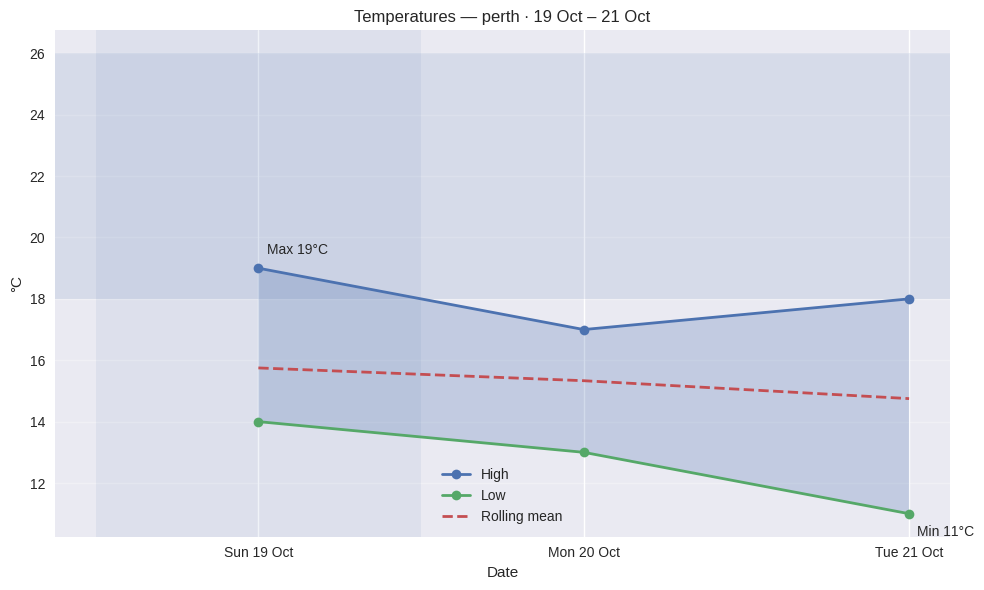

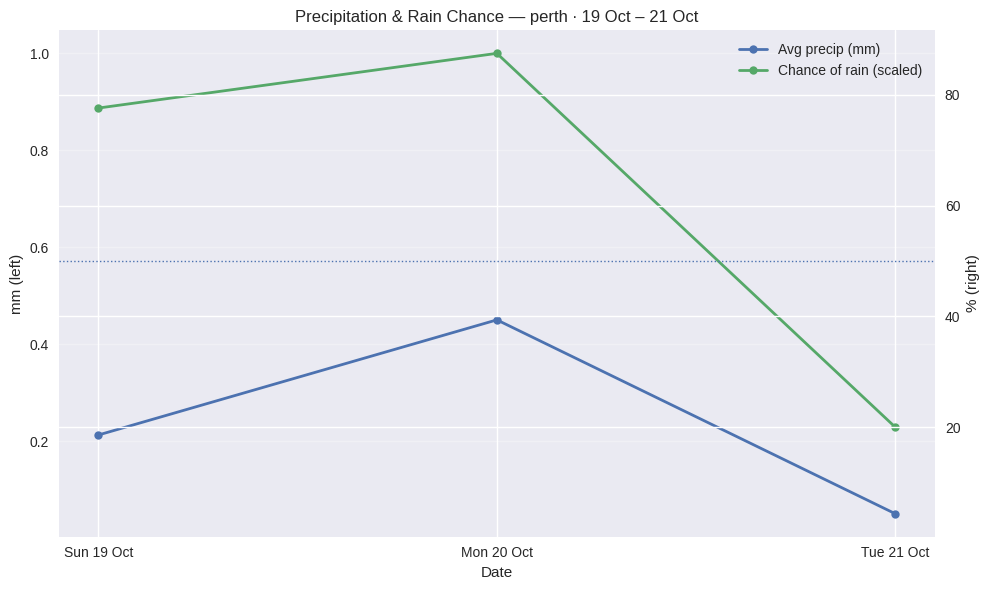

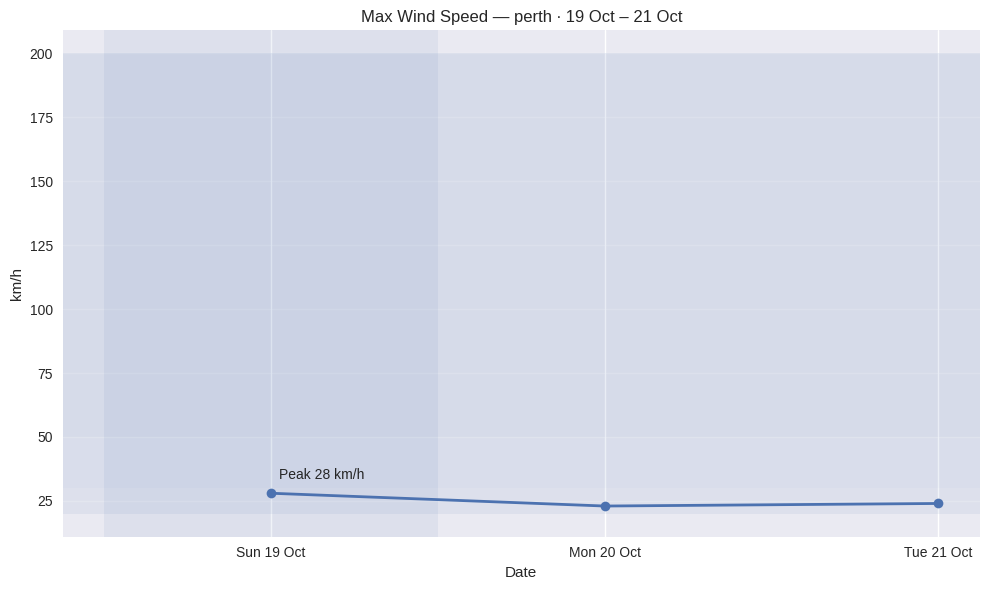

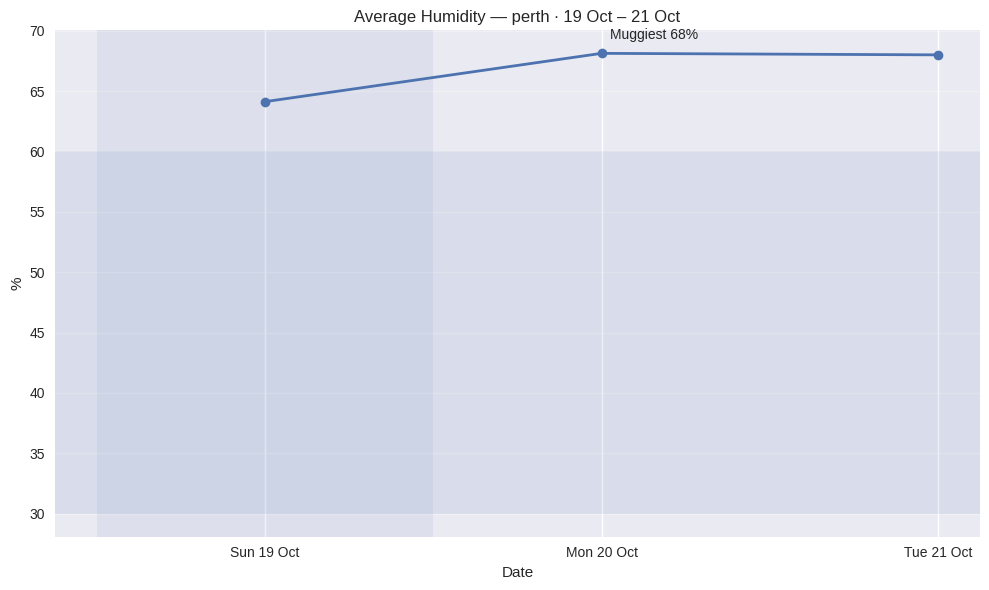


Main Menu:
- [1] Weather Forecast
- [2] Ask Question
- [3] Example Questions
- [4] Exit
Your choice: 

In [ ]:
# Tie everything together here


if __name__ == "__main__":
    main_menu()

## 🧪 Testing and Examples

✅ PASS: Rejects empty city string
✅ PASS: get_weather_data('') error check
✅ PASS: Rejects whitespace city
✅ PASS: get_weather_data('   ') error check
✅ PASS: Live fetch returns forecast list
✅ PASS: Live fetch has display_location
✅ PASS: Live fetch basic sanity
✅ PASS: Temperature visualisation returns a figure
✅ PASS: Temperature viz
✅ PASS: Precipitation visualisation returns a figure
✅ PASS: Precipitation viz
✅ PASS: Humidity visualisation returns a figure
✅ PASS: Humidity viz
✅ PASS: Wind visualisation returns a figure
✅ PASS: Wind viz
✅ PASS: NLP identifies precipitation intent
✅ PASS: NLP extracts time period
✅ PASS: NLP finds a location or leaves it None (UI prompts)
✅ PASS: NLP basic parsing
✅ PASS: NLP maps clothing to temperature (jacket)
✅ PASS: NLP reads 'today'
✅ PASS: NLP jacket intent
✅ PASS: Text mentions chance of rain
✅ PASS: Text generation: precipitation
✅ PASS: Text mentions temperature
✅ PASS: Text generation: temperature
✅ PASS: Text includes sunrise time
✅ PAS

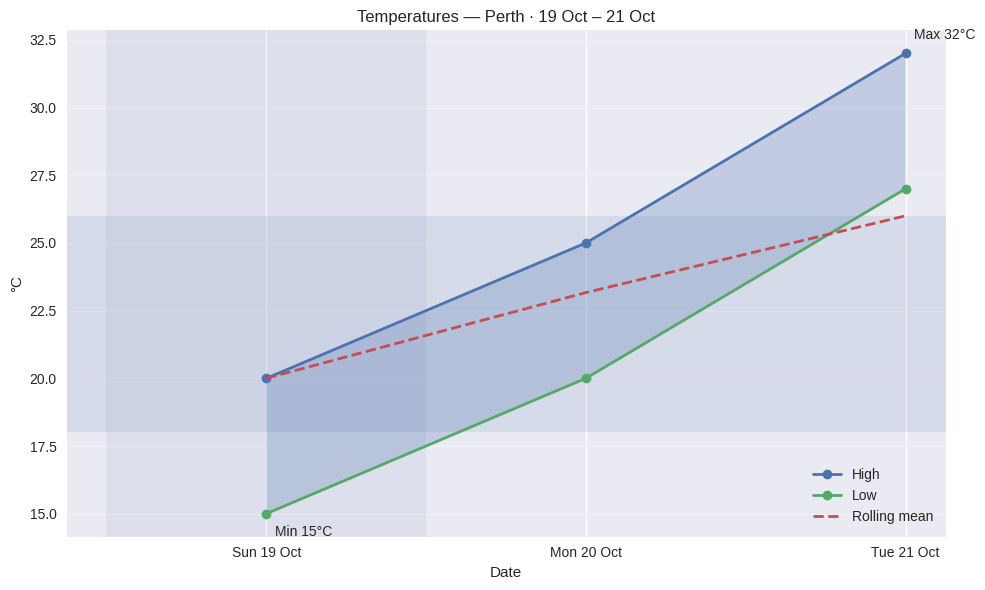

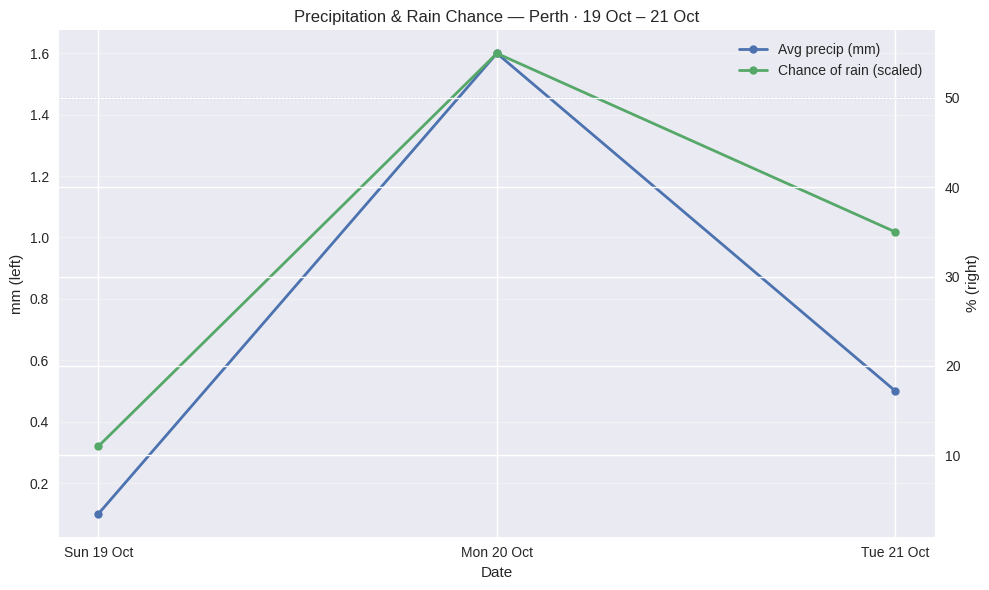

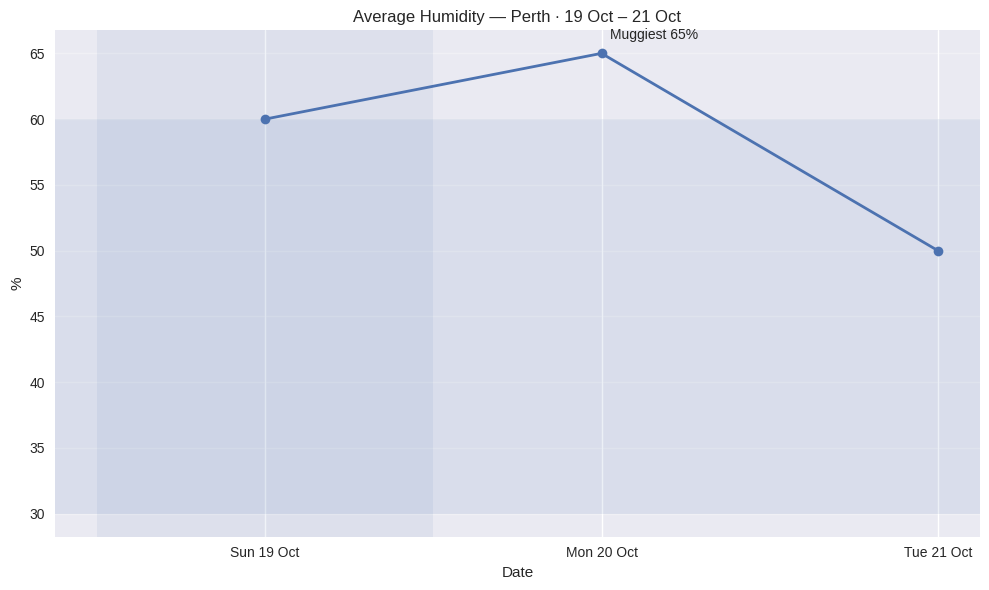

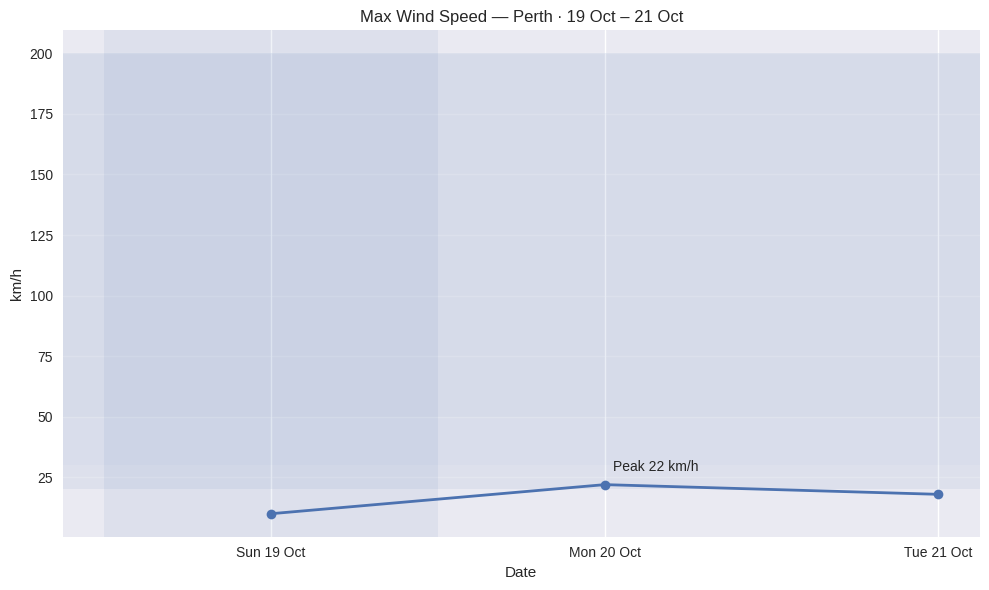

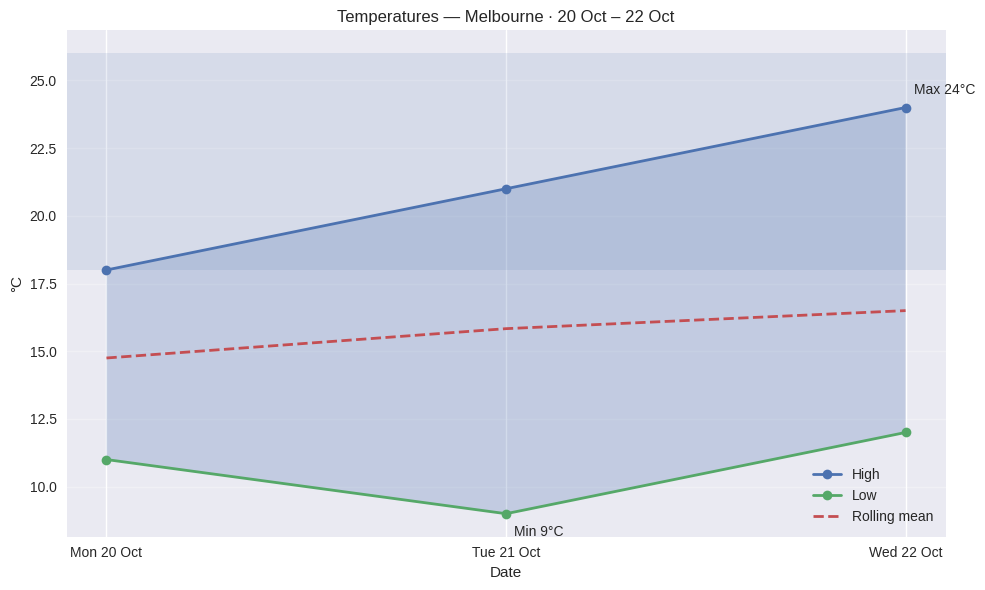

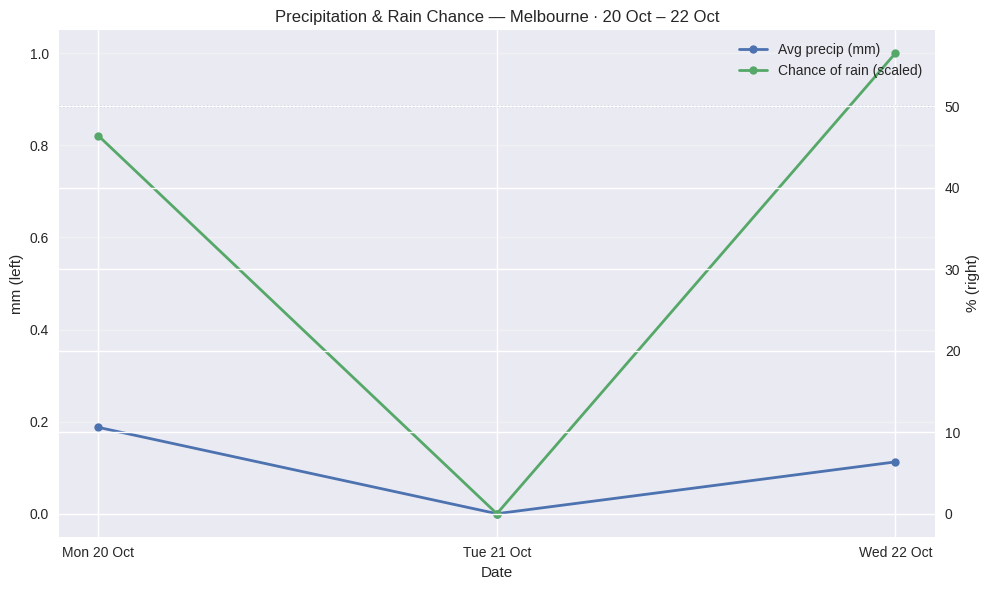

In [11]:
# Include sample input/output for each function


# ===================== TEST SUITE =====================
from datetime import datetime, timedelta
import traceback

PASS = 0
FAIL = 0

def _ok(cond, msg):
    global PASS, FAIL
    if cond:
        PASS += 1
        print(f"✅ PASS: {msg}")
    else:
        FAIL += 1
        print(f"❌ FAIL: {msg}")

def _try(callable_fn, msg):
    """Run callable and record pass/fail without crashing the test suite."""
    try:
        callable_fn()
        _ok(True, msg)
    except Exception as e:
        print(f"❌ FAIL: {msg}")
        print("   ", e)
        traceback.print_exc()
        global FAIL
        FAIL += 1

# ---------- Mock data builder (works offline) ----------
def _mock_wttrin_day(date_obj, *, base_temp=20, pop=40, precip_mm=0.6, hum=55, wind=15, desc="Partly cloudy"):
    """Build one day in the shape wttr.in returns, including hourly + astronomy."""
    hours = []
    # 8 hourly chunks (3-hourly like wttr.in)
    for i in range(8):
        hours.append({
            "time": f"{i*300:04d}",
            "tempC": base_temp + (i % 3) - 1,  # a bit of variation
            "FeelsLikeC": base_temp + (i % 3) - 1,
            "chanceofrain": pop,
            "precipMM": precip_mm,
            "humidity": hum,
            "windspeedKmph": wind,
            "weatherDesc": [{"value": desc}],
        })
    return {
        "date": date_obj.strftime("%Y-%m-%d"),
        "astronomy": [{"sunrise": "06:12 AM", "sunset": "06:35 PM"}],
        "maxtempC": base_temp + 3,
        "mintempC": base_temp - 2,
        "avgtempC": base_temp,
        "hourly": hours,
    }

def make_mock_data(city="Perth"):
    today = datetime.now().date()
    return {
        "source": "wttr.in",
        "requested_location": city,
        "display_location": city,
        "location": city,
        "resolved_location": city,
        "resolved_similarity": 1.0,
        "current": {},
        "forecast": [
            _mock_wttrin_day(today + timedelta(days=0), base_temp=17, pop=11, precip_mm=0.1, hum=60, wind=10, desc="Clear"),
            _mock_wttrin_day(today + timedelta(days=1), base_temp=22, pop=55, precip_mm=1.6, hum=65, wind=22, desc="Light rain"),
            _mock_wttrin_day(today + timedelta(days=2), base_temp=29, pop=35, precip_mm=0.5, hum=50, wind=18, desc="Sunny"),
        ],
        "raw": {}
    }

# ---------- Tests ----------

# 1) get_weather_data: input validation
_try(lambda: _ok("error" in get_weather_data(""), "Rejects empty city string"), "get_weather_data('') error check")
_try(lambda: _ok("error" in get_weather_data("   "), "Rejects whitespace city"), "get_weather_data('   ') error check")

# 2) get_weather_data: live fetch (skip if offline/error)
def _live_fetch_test():
    sample = get_weather_data("Melbourne")
    if isinstance(sample, dict) and "error" not in sample:
        _ok("forecast" in sample and len(sample["forecast"]) >= 1, "Live fetch returns forecast list")
        _ok("display_location" in sample, "Live fetch has display_location")
    else:
        print("ℹ️ Live fetch skipped (offline or provider issue). This is OK.")
        _ok(True, "Live fetch optional")
_try(_live_fetch_test, "Live fetch basic sanity")

# 3) Visualisations: work with mock data, return figures (no crash)
def _viz_temp():
    fig = create_temperature_visualisation(make_mock_data(), output_type='figure')
    _ok(fig is not None, "Temperature visualisation returns a figure")
def _viz_precip():
    fig = create_precipitation_visualisation(make_mock_data(), output_type='figure')
    _ok(fig is not None, "Precipitation visualisation returns a figure")
def _viz_hum():
    fig = create_humidity_visualisation(make_mock_data(), output_type='figure')
    _ok(fig is not None, "Humidity visualisation returns a figure")
def _viz_wind():
    fig = create_wind_visualisation(make_mock_data(), output_type='figure')
    _ok(fig is not None, "Wind visualisation returns a figure")

_try(_viz_temp,   "Temperature viz")
_try(_viz_precip, "Precipitation viz")
_try(_viz_hum,    "Humidity viz")
_try(_viz_wind,   "Wind viz")

# 4) NLP: parsing coverage
def _nlp_basic():
    pq = smart_parse_weather_question("Will it rain tomorrow in Paris?")
    _ok(pq.get("attribute") in {"precipitation","rain"}, "NLP identifies precipitation intent")
    _ok(pq.get("time_period") in {"tomorrow","today","weekend"} or pq.get("time_period") in
        ["monday","tuesday","wednesday","thursday","friday","saturday","sunday"], "NLP extracts time period")
    _ok(pq.get("location") is not None or True, "NLP finds a location or leaves it None (UI prompts)")
_try(_nlp_basic, "NLP basic parsing")

def _nlp_jacket():
    pq = smart_parse_weather_question("Do I need a jacket today in Perth?")
    _ok(pq.get("attribute") == "temperature", "NLP maps clothing to temperature (jacket)")
    _ok(pq.get("time_period") == "today", "NLP reads 'today'")
_try(_nlp_jacket, "NLP jacket intent")

# 5) Text answers (mock data so it's deterministic)
def _text_precip():
    pq = {"location": "Perth", "attribute": "precipitation", "time_period": "tomorrow", "style": {"wants_umbrella": True}}
    msg = generate_weather_response(pq, make_mock_data())
    _ok("chance of rain" in msg.lower(), "Text mentions chance of rain")
def _text_temp():
    pq = {"location": "Perth", "attribute": "temperature", "time_period": "today", "style": {"wants_jacket": True}}
    msg = generate_weather_response(pq, make_mock_data())
    _ok("temperature" in msg.lower(), "Text mentions temperature")
def _text_sunrise():
    pq = {"location": "Perth", "attribute": "sunrise", "time_period": "today", "style": {}}
    msg = generate_weather_response(pq, make_mock_data())
    _ok("sunrise is at" in msg.lower(), "Text includes sunrise time")
_try(_text_precip,  "Text generation: precipitation")
_try(_text_temp,    "Text generation: temperature")
_try(_text_sunrise, "Text generation: sunrise")

# 6) Smoke test (fixed to use smart_parse_weather_question)
def _smoke():
    sample = get_weather_data('Melbourne')
    if isinstance(sample, dict) and "error" not in sample:
        # don't display plots in tests; still ensure they run
        create_temperature_visualisation(sample, output_type='figure')
        create_precipitation_visualisation(sample, output_type='figure')
        pq = smart_parse_weather_question("Will it rain tomorrow in Paris?")
        loc = pq.get("location") or "Paris"
        pdata = get_weather_data(loc)
        # Even if fetch fails, the generator handles error messages
        print(generate_weather_response(pq, pdata))
        _ok(True, "Smoke test completed")
    else:
        print("ℹ️ Smoke test skipped due to live fetch issue.")
        _ok(True, "Smoke test optional")
_try(_smoke, "Smoke test")

print("\n====================")
print(f"Tests completed — PASS: {PASS}  FAIL: {FAIL}")
print("====================")




## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.